# Lagranigian NN (LNN) evaluation
by Jae Hoon (Daniel) Lee

- Some of rountines have been borrowed from Y. Chen's train codes.

In [1]:
import torch
from torch.autograd import grad
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
solver = scipy.integrate.solve_ivp

In [ ]:
import torch.nn as nn
device = 'cpu'

In [ ]:
class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2
            qqd = x.requires_grad_(True) 

            L = self._lagrangian(qqd).sum() 

            J = grad(L, qqd, create_graph=True)[0] 

            DL_q, DL_qd = J[:,:n], J[:,n:]

            DDL_qd = []
            for i in range(n):
                J_qd_i = DL_qd[:,i][:,None] 
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                                                                       
                DDL_qd.append(H_i)

            DDL_qd = torch.cat(DDL_qd, 2)

            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            ''' original code (Y. Chen) ''' 
            # # T = DDL_qqd * v (아인슈타인 합 규약 사용)
            # T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:])
            
            ''' replaced by me '''
            v = qqd[:,n:].unsqueeze(-1) 
            T = DDL_qqd @ v
            T = T.squeeze(-1) 

            ''' original code (Y. Chen) '''
            # # G = DL_q - T
            # # qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)
            # qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)

            ''' replaced by me '''
            G = (DL_q - T).unsqueeze(-1)
            qdd = DDL_qdqd.inverse() @ G
            qdd = qdd.squeeze(-1)

        return torch.cat([qqd[:,self.n:], qdd], 1)
    def _lagrangian(self, qqd):
        return self.L(qqd)    
    def energy(self, qqd):
        n = qqd.shape[1]//2
        lag = self.L(qqd)
        lag_sum = lag.sum()
        lag_grad = grad(lag_sum, qqd, create_graph=False)[0]
        DL_q, DL_qd = lag_grad[:,:n], lag_grad[:,n:]
        dq = qqd[:,n:]

        inner_prod = (dq*DL_qd).sum(1, keepdim=True)

        ''' original code (Y. Chen) '''
        # energy = lag - inner_prod

        ''' corrected because the theoretical inconsistency of the original code '''
        # To comply with H = v ⋅ p - L, changed sign
        energy = inner_prod - lag 
        return energy 

In [4]:
import time
input_size = 4
hidden_size = 200
output_size = 1
num_trials = 10

In [ ]:
M = 100 * 1
tend = 5.0 * 1
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]

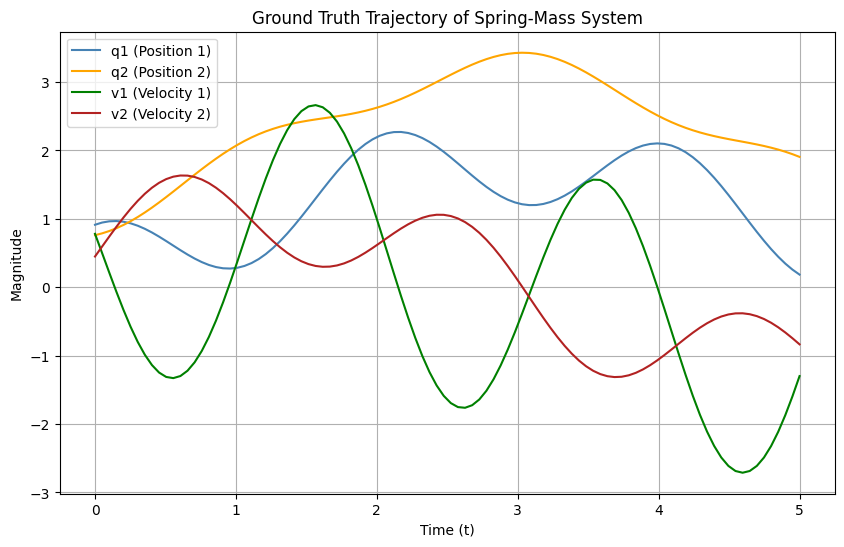

In [ ]:
# Ground truth
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

# equations of motion
def func(t, state):
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (-k1*(state[0]-l1)+k2*(state[1]-state[0]-l2))/m1
  dvdt[3] = -k2*(state[1]-state[0]-l2)/m2
  return dvdt

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

for i in range(1):
  sol = solver(func, [0, tend], state[i], t_eval=t_eval)
  tval = sol['t']

  # ODE in/out v: = (q1, q2, v1, v2) order
  q1 = sol['y'][0]
  q2 = sol['y'][1]
  v1 = sol['y'][2]
  v2 = sol['y'][3]
  tval = sol['t']

  plt.figure(figsize=(10, 6))
  plt.plot(tval, q1, 'steelblue', label='q1 (Position 1)')
  plt.plot(tval, q2, 'orange', label='q2 (Position 2)')
  plt.plot(tval, v1, 'g', label='v1 (Velocity 1)')
  plt.plot(tval, v2, 'firebrick', label='v2 (Velocity 2)')
  plt.xlabel('Time (t)')
  plt.ylabel('Magnitude')
  plt.title('Ground Truth Trajectory of Spring-Mass System')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
# For comparison between the ground truth and model
true_res = []

for i in range(q1.shape[0]):
    true_res.append(np.array([q1[i], q2[i], v1[i], v2[i]]))

true_res = np.array(true_res)
print('true_res:', true_res.shape)

true_res: (100, 4)


In [8]:
import pandas as pd
A = pd.read_csv("./data/A_ms_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_ms_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

l_nn = LNN(nn.Sequential(
          nn.Linear(input_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,hidden_size),
          nn.Tanh(),
          nn.Linear(hidden_size,output_size))
       ).to(device)

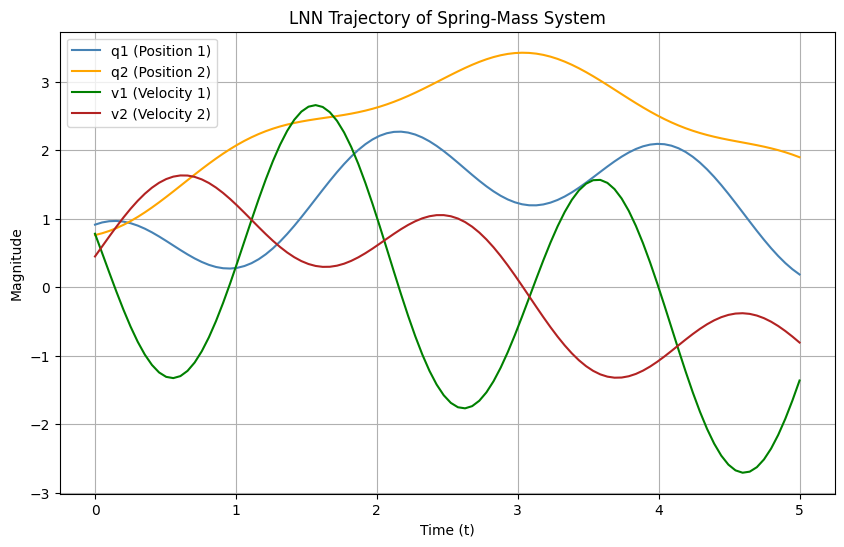

In [ ]:
# simulation
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

trial = 9

state = []
for i in range(1):
  s = (0.91369884, 0.76173912, 0.7811432,  0.44947022)
  state.append(s)

l_nn.load_state_dict(torch.load("./model/danieljh_lnn_ms_sep_sc_min_2t_lr_{}".format(trial), map_location=device))
l_nn.eval()
x0 = state[0]

A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
l_nn.cpu()

def fvec_np(x,t):
    tx = torch.tensor(x, dtype=torch.float).unsqueeze(0)
    x = torch.matmul(tx, torch.inverse(B))

    output = l_nn.forward(x).squeeze(0)
    output = torch.matmul(A, output)
    output = output.squeeze(0)
    return output.detach().cpu().numpy() 


res = scipy.integrate.odeint(fvec_np,x0,t_eval)

plt.figure(figsize=(10, 6))
plt.plot(t_eval,res[:,0], 'steelblue', label='q1 (Position 1)')
plt.plot(t_eval,res[:,1], 'orange', label='q2 (Position 2)')
plt.plot(t_eval,res[:,2], 'g', label='v1 (Velocity 1)')
plt.plot(t_eval,res[:,3], 'firebrick', label='v2 (Velocity 2)')
plt.xlabel('Time (t)')
plt.ylabel('Magnitude')
plt.title('LNN Trajectory of Spring-Mass System')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def Hamiltonian_ftn(state):
    """
    Computes the total energy (Hamiltonian) of the system
    based on the given state vector (q1, q2, v1, v2)
    """
    q1 = state[0]
    q2 = state[1]
    v1 = state[2]
    v2 = state[3]
    
    # Kinetic Energy: K = 0.5 * m * v^2
    kinetic = 0.5 * (m1 * (v1**2) + m2 * (v2**2))
    
    # Potential Energy V = 0.5 * k * x^2
    potential = 0.5 * (k1 * (q1-l1)**2 + k2 * (q2-q1-l2)**2)

    return (kinetic + potential)

def true_energy(trajectory):
    """
    Computes time series of energy for the trajectory.
    
    Args:
        trajectory (np.ndarray): (number of time steps, 4) shape time-series data
    Returns:
        np.ndarray: energy per time step
    """
    energies = []
    for state_t in trajectory:
        energies.append(Hamiltonian_ftn(state_t))

    return np.array(energies)

In [11]:
print('res:', res.shape)

res: (100, 4)


In [ ]:
tres = torch.tensor(res, dtype=torch.float, requires_grad=True)
net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
Hmodel_lnn_x = net_energy.detach().cpu().numpy()

tres = torch.tensor(true_res, dtype=torch.float, requires_grad=True)
net_energy = l_nn.energy(torch.matmul(tres, torch.inverse(B)))
Hmodel_true_x = net_energy.detach().cpu().numpy()

Htrue_lnn_x = true_energy(res).reshape((M))
Htrue_true_x = true_energy(true_res).reshape((M))

In [ ]:
def plot_2x2_figure(true_res, res, t_eval, Htrue_true_x, Htrue_hnn_x, Hmodel_true_x, Hmodel_hnn_x):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    tpad = 7

    # --- Top Left Plot (0, 0): Ground Truth Trajectory ---
    axes[0, 0].plot(t_eval, true_res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 0].plot(t_eval, true_res[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 0].plot(t_eval, true_res[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 0].plot(t_eval, true_res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_title('Ground Truth Orbit')
    axes[0, 0].legend(loc='upper right', fontsize=8)
    axes[0, 0].grid(True)

    # --- Top Right Plot (0, 1): Model Prediction Trajectory ---
    axes[0, 1].plot(t_eval, res[:, 0], 'steelblue', label='q1 (Position 1)')
    axes[0, 1].plot(t_eval, res[:, 1], 'g', label='q2 (Position 2)')
    axes[0, 1].plot(t_eval, res[:, 2], 'orange', label='v1 (Velocity 1)')
    axes[0, 1].plot(t_eval, res[:, 3], 'firebrick', label='v2 (Velocity 2)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_title('LNN Orbit')
    axes[0, 1].legend(loc='upper right', fontsize=8)
    axes[0, 1].grid(True)

    # --- Bottom Left Plot (1, 0): True Hamiltonian Perspective ---
    axes[1, 0].plot(t_eval, Htrue_true_x, 'k-', label='H_true(True_x)', linewidth=2)
    axes[1, 0].plot(t_eval, Htrue_lnn_x, 'b--', label='H_true(LNN_x)', linewidth=2)
    axes[1, 0].set_title("True Energy (u)", pad=tpad)
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Energy E(u)')
    axes[1, 0].legend(fontsize=8)
    axes[1, 0].grid(True)

    # --- Bottom Right Plot (1, 1): Learned Hamiltonian Perspective ---
    axes[1, 1].plot(t_eval, Hmodel_true_x, 'k-', label='E_model(True_x)', linewidth=2)
    axes[1, 1].plot(t_eval, Hmodel_lnn_x, 'b--', label='E_model(LNN_x)', linewidth=2)
    axes[1, 1].set_title("Energy Learned by Lagrangian NN (u)", pad=tpad)
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Energy E_model(u)')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig("./eval_figures_per_model/lnn_ms_eval_figure_by_danieljh.png", dpi=150) # PNG saved
    plt.show()


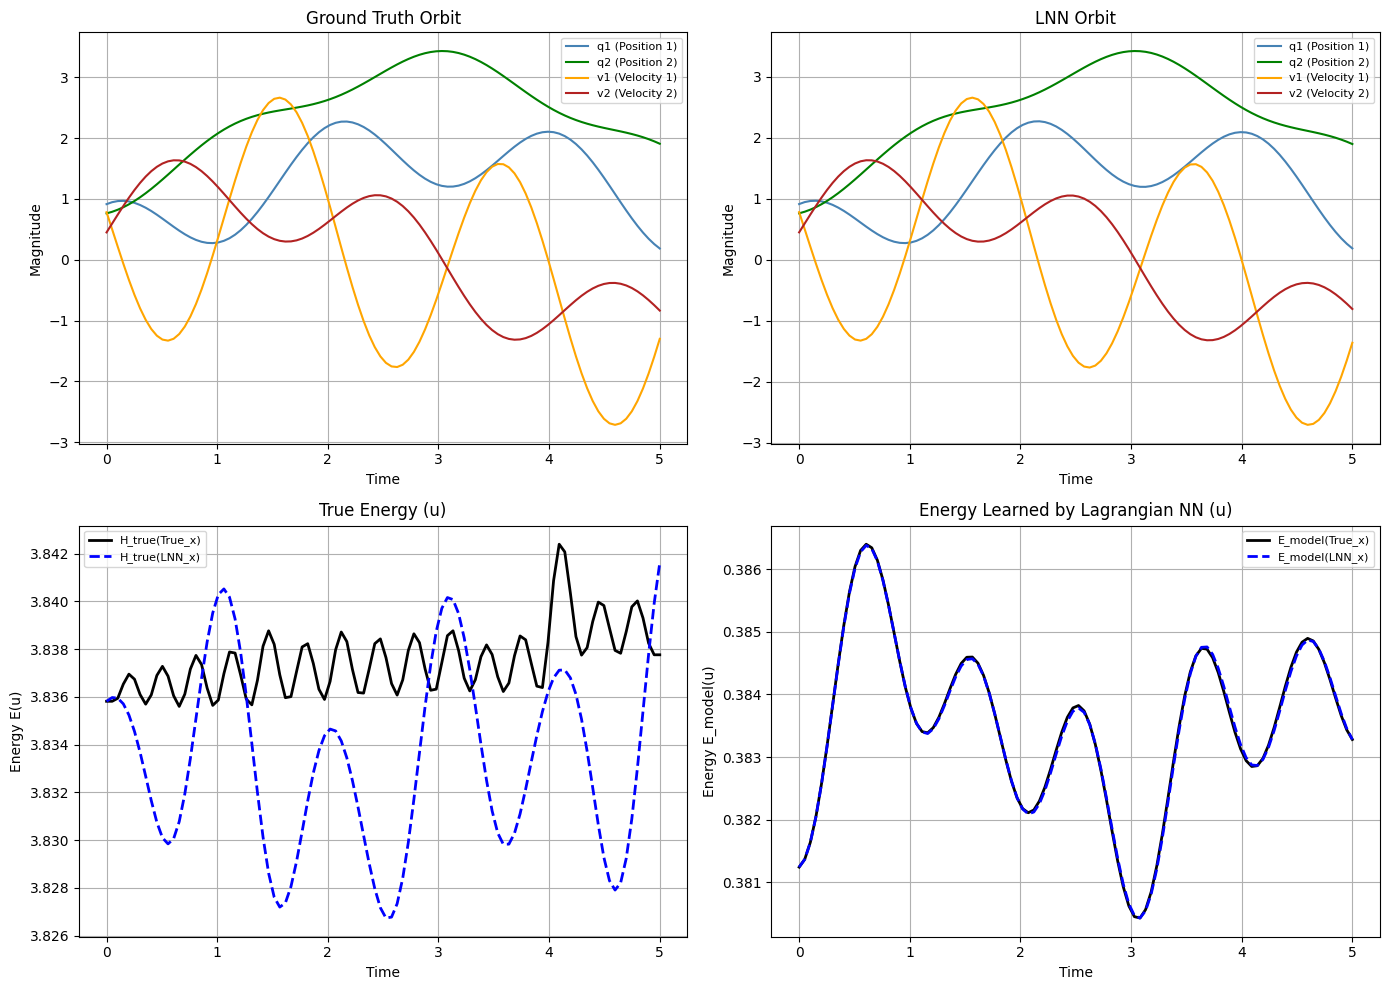

In [14]:
plot_2x2_figure(true_res, res, t_eval, Htrue_true_x, Htrue_lnn_x, Hmodel_true_x, Hmodel_lnn_x)

In [ ]:
''' In order to compare performances across models, exports orbit, etc. to file '''
def save_data(data, model="TRUE_ms", item='orbit', t_end=tend, dir = './comparison'): 
    # model = "TRUE", "HNN" "LNN", "SYM", "SKEW", "NODE"
    file_path = dir + f'/{model}_{item}_tend_{t_end}.npy'
    np.save(file_path, data)

    print(f"Data have successfully saved to {file_path}.")

In [ ]:
save_data(true_res)
save_data(res, model="LNN_ms")
save_data(Htrue_true_x, model="TRUE_ms", item="Htrue_true_x")
save_data(Htrue_lnn_x, model="TRUE_ms", item='Htrue_lnn_x')
save_data(Hmodel_true_x, model="LNN_ms", item='Hmodel_true_x')
save_data(Hmodel_lnn_x, model="LNN_ms", item='Hmodel_lnn_x')

데이터가 ./comparison/TRUE_ms_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/LNN_ms_orbit_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_ms_Htrue_true_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/TRUE_ms_Htrue_lnn_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/LNN_ms_Hmodel_true_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
데이터가 ./comparison/LNN_ms_Hmodel_lnn_x_tend_5.0.npy 파일로 성공적으로 저장되었습니다.
